In [99]:
sys.path.append(os.path.abspath('./../../'))
from cell_extractor.CellDetector import CellDetector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,sys
sys.path.append(os.path.abspath('./../../'))
from Controllers.MarkedCellController import MarkedCellController
from Controllers.SqlController import SqlController
from model.annotation_points import MarkedCellView
from sqlalchemy import inspect
inst = inspect(MarkedCellView)
attr_names = [c_attr.key for c_attr in inst.mapper.column_attrs]
import pandas as pd
from cell_extractor.AnnotationProximityTool import AnnotationProximityTool
import numpy as np
user_look_up = {38:'Marissa',41:'Julian'}
from cell_extractor.CellAnnotationUtilities import CellAnnotationUtilities
from matplotlib.patches import Patch
def get_DataFrame_from_query_result(results,category,factor):
    values = []
    for i in results:
        source = i.source.value
        if '-' in source:
            source = source.split('-')[1]    
        x,y,z = np.array([i.x,i.y,i.z]).astype(float)/factor
        values.append([x,y,z,f'{category}_{user_look_up[i.FK_annotator_id]}_{source}'])
    # values = [[eval(f'j.{i}')  for j in results ] for i in attr_names]
    pd.DataFrame(dict(zip(['x','y','section','name'],np.array(values).T))).head()
    df = pd.DataFrame(dict(zip(['x','y','section','name'],np.array(values).T)))
    df["x"] = pd.to_numeric(df["x"])
    df["y"] = pd.to_numeric(df["y"])
    df["section"] = pd.to_numeric(df["section"])
    return df

def find_equivalence(points,distance = 0.1):
    tool = AnnotationProximityTool()
    tool.pair_distance=distance
    tool.set_annotations_to_compare(points)
    tool.find_equivalent_points()
    return tool

def find_annotation_in_category(tool,category):
    incategory = []
    for id,group in tool.pairs.items():
            if tool.pair_categories[id] in category:
                    incategory.append(tool.annotations_to_compare.iloc[group[0]])
    incategory = pd.concat(incategory,axis=1).T
    return incategory

def find_agreement(tool,agree,disagree):
    agreed = find_annotation_in_category(tool,agree)
    disagreed = find_annotation_in_category(tool,disagree)
    return agreed,disagreed

def print_unique_combination(tool):
    dictionary = []
    for i in tool.pair_categories.values():
        if not i in dictionary:
            dictionary.append(i)
    for key,val in dictionary.items():
        print(key,val)

In [56]:
animali = 'DK41'
detector = CellDetector(animali,round = 2)
detections = detector.load_detections()
sures = detections[detections.predictions==2]
unsures = detections[detections.predictions==0]
nodetection = detections[detections.predictions<0]

In [5]:
detections.head()

,animal,section,row,col,label,mean_score,std_score,predictions
0,DK41,347,5364,28747,0.0,-3.753175,1.660697,-2
1,DK41,347,5324,28755,0.0,-4.274146,1.619854,-2
2,DK41,347,5334,28704,0.0,-8.031691,1.333832,-2
3,DK41,347,5337,28674,0.0,-4.631068,0.967737,-2
4,DK41,347,5338,28678,0.0,-8.720782,1.677284,-2


In [74]:
controller = SqlController()
factor = controller.get_resolution(animali)
controller = MarkedCellController()
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':16}
round3_sures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Sure',factor)
round3_sures_tool = find_equivalence(round3_sures)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':17}
round3_unsures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Unsure',factor)
round3_unsures_tool = find_equivalence(round3_unsures)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':19}
connected = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Connected',factor)
connected_tool = find_equivalence(connected)
search_dict = {'FK_prep_id':animali,'FK_cell_type_id':18}
false_negatives = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'False_negative',factor)
false_negatives_tool = find_equivalence(false_negatives,distance=5)


calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 1000
after removing duplicates 500
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 8982
after removing duplicates 4491
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 43
after removing duplicates 43
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 917
after removing duplicates 778


In [15]:
positive = [['Sure_Marissa_POSITIVE', 'Sure_Julian_POSITIVE']]
negative = [['Sure_Marissa_NEGATIVE', 'Sure_Julian_NEGATIVE']]
disagree = [['Sure_Marissa_NEGATIVE', 'Sure_Julian_POSITIVE'],['Sure_Marissa_POSITIVE', 'Sure_Julian_NEGATIVE']]
round3_sure_positive = find_annotation_in_category(round3_sures_tool,positive)
round3_sure_negative = find_annotation_in_category(round3_sures_tool,negative)
round3_sure_disagree = find_annotation_in_category(round3_sures_tool,disagree)

In [17]:
positive = [['Unsure_Marissa_POSITIVE', 'Unsure_Julian_POSITIVE']]
negative = [['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_NEGATIVE']]
disagree = [['Unsure_Marissa_POSITIVE', 'Unsure_Julian_NEGATIVE'],['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_POSITIVE']]
round3_unsure_positive = find_annotation_in_category(round3_unsures_tool,positive)
round3_unsure_negative = find_annotation_in_category(round3_unsures_tool,negative)
round3_unsure_disagree = find_annotation_in_category(round3_unsures_tool,disagree)

In [75]:
agree = [['False_negative_Julian_POSITIVE', 'False_negative_Marissa_POSITIVE'],]
disagree = [['False_negative_Julian_POSITIVE'],['False_negative_Marissa_POSITIVE']]
false_negatives_agreed,false_negatives_disagreed = find_agreement(false_negatives_tool,agree,disagree)

In [82]:
def get_features_in_subcategory(big_category,subcatgory,max_distance=20):
    more_points = np.array([big_category.col,big_category.row,big_category.section]).T.astype(float)
    less_points = np.array([subcatgory.x,subcatgory.y,subcatgory.section]).T.astype(float)
    util = CellAnnotationUtilities()
    ids = util.find_cloest_neighbor_among_points(more_points,less_points,max_distance=max_distance)
    return big_category.iloc[ids]


In [77]:
len(false_negatives_agreed)

139

In [88]:
sure_positive_features = get_features_in_subcategory(sures,round3_sure_positive)
sure_negative_features = get_features_in_subcategory(sures,round3_sure_negative)
sure_disagree_features = get_features_in_subcategory(sures,round3_sure_disagree)

unsure_positive_features = get_features_in_subcategory(unsures,round3_unsure_positive)
unsure_negative_features = get_features_in_subcategory(unsures,round3_unsure_negative)
unsure_disagree_features = get_features_in_subcategory(unsures,round3_unsure_disagree)

false_negative_agreed = get_features_in_subcategory(nodetection,false_negatives_agreed,max_distance=300)
false_negative_disagreed = get_features_in_subcategory(nodetection,false_negatives_disagreed,max_distance=300)


1000
skipping, min distance 874.9139873193805
skipping, min distance 458.9289037511417
skipping, min distance 729.7002287962595
skipping, min distance 903.4768346610947
skipping, min distance 975.1233088464365
skipping, min distance 443.36755959295226
skipping, min distance 328.2420311384836
skipping, min distance 320.9143187830671
skipping, min distance 436.86578714330506
skipping, min distance 401.8630153135763
skipping, min distance 3598.805551879219
skipping, min distance 2378.5343225006477
skipping, min distance 3360.1724956074336
skipping, min distance 1854.6654624895316
skipping, min distance 1229.6561559131676
skipping, min distance 7135.933593188108
skipping, min distance 5733.215143107728
skipping, min distance 752.093543533549
skipping, min distance 642.6661700710914
skipping, min distance 318.24675960644123
skipping, min distance 305.1119689711763
skipping, min distance 2641.977317650977
skipping, min distance 971.5317040997726
skipping, min distance 512.9801168044296
skipp

In [90]:
print(f'sures {len(sure_positive_features),len(sure_negative_features),len(sure_disagree_features)}')
print(f'unsures {len(unsure_positive_features),len(unsure_negative_features),len(unsure_disagree_features)}')
print(f'false neg {len(false_negative_agreed),len(false_negative_disagreed)}')

sures (196, 48, 56)
unsures (266, 1011, 63)
false neg (136, 605)


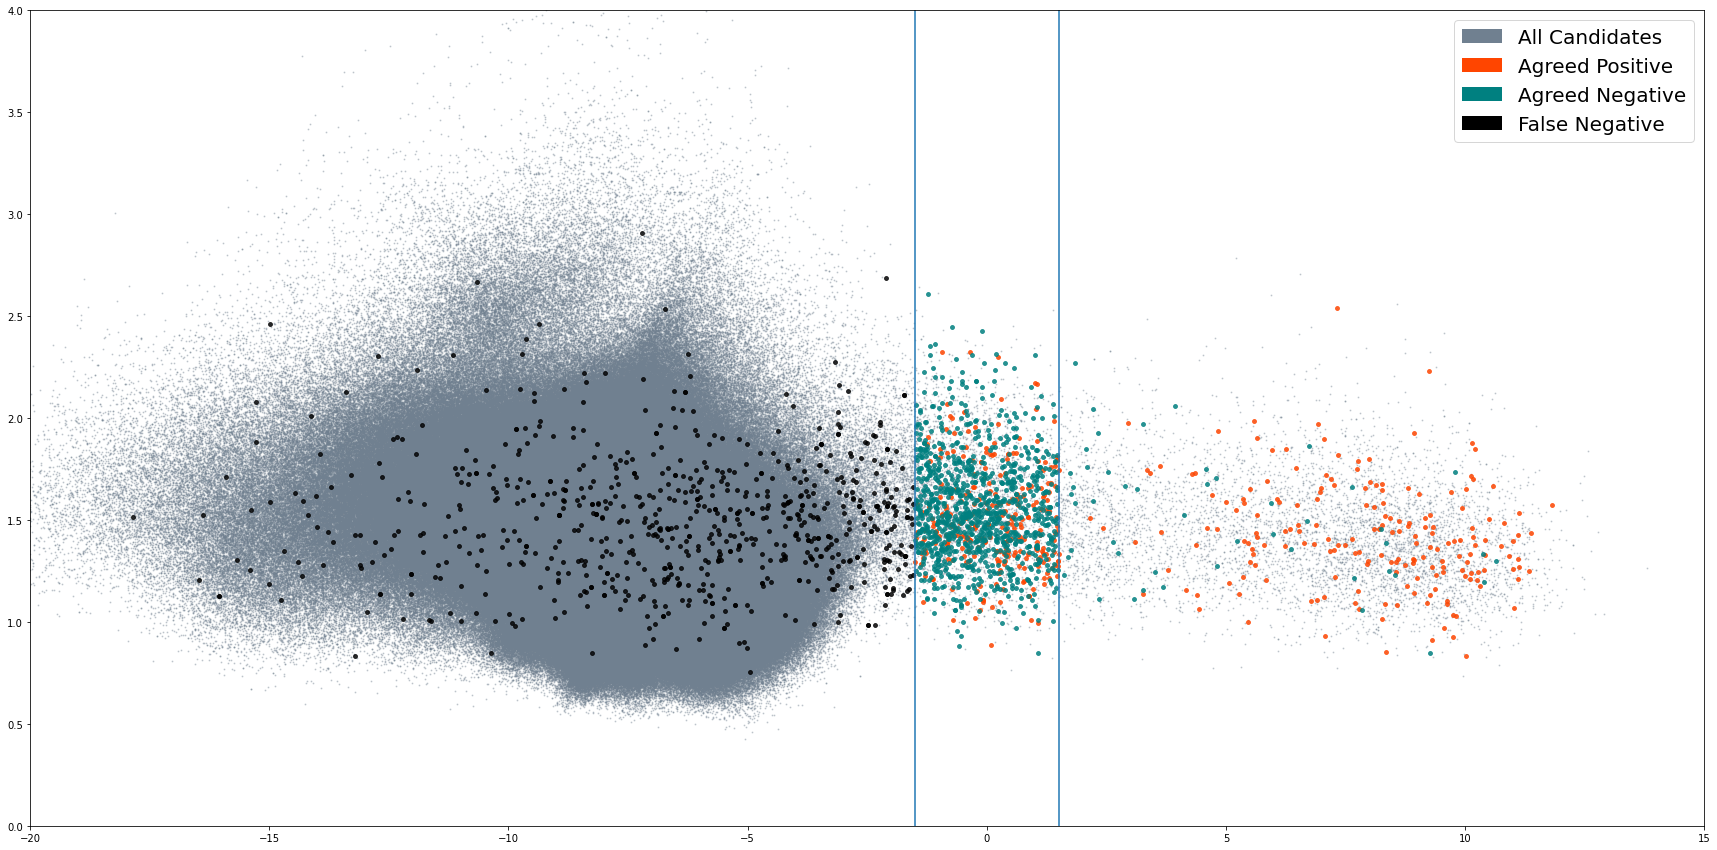

In [114]:
plt.figure(figsize=[30,15])
alpha = 0.8
size = 15
plt.scatter(detections['mean_score'].to_numpy(),detections['std_score'].to_numpy(),color='slategrey',s=1,alpha=0.3)
plt.scatter(sure_positive_features['mean_score'].to_numpy(),sure_positive_features['std_score'].to_numpy(),color='orangered',s=size,alpha=alpha)
plt.scatter(unsure_positive_features['mean_score'].to_numpy(),unsure_positive_features['std_score'].to_numpy(),color='orangered',s=size,alpha=alpha)
plt.scatter(sure_negative_features['mean_score'].to_numpy(),sure_negative_features['std_score'].to_numpy(),color='teal',s=size,alpha=alpha)
plt.scatter(unsure_negative_features['mean_score'].to_numpy(),unsure_negative_features['std_score'].to_numpy(),color='teal',s=size,alpha=alpha)
plt.scatter(false_negative_agreed['mean_score'].to_numpy(),false_negative_agreed['std_score'].to_numpy(),color='black',s=size,alpha=alpha)
plt.scatter(false_negative_disagreed['mean_score'].to_numpy(),false_negative_disagreed['std_score'].to_numpy(),color='black',s=size,alpha=alpha)
plt.xlim([-20,15])
plt.ylim([0,4])
plt.axvline(-1.5)
plt.axvline(1.5)
label1 = Patch(facecolor='slategrey',label='All Candidates')
label2 = Patch(facecolor='orangered',label='Agreed Positive')
label3 = Patch(facecolor='teal',label='Agreed Negative')
label4 = Patch(facecolor='black',label='False Negative')
plt.legend(handles=[label1,label2,label3,label4],prop={'size':20})

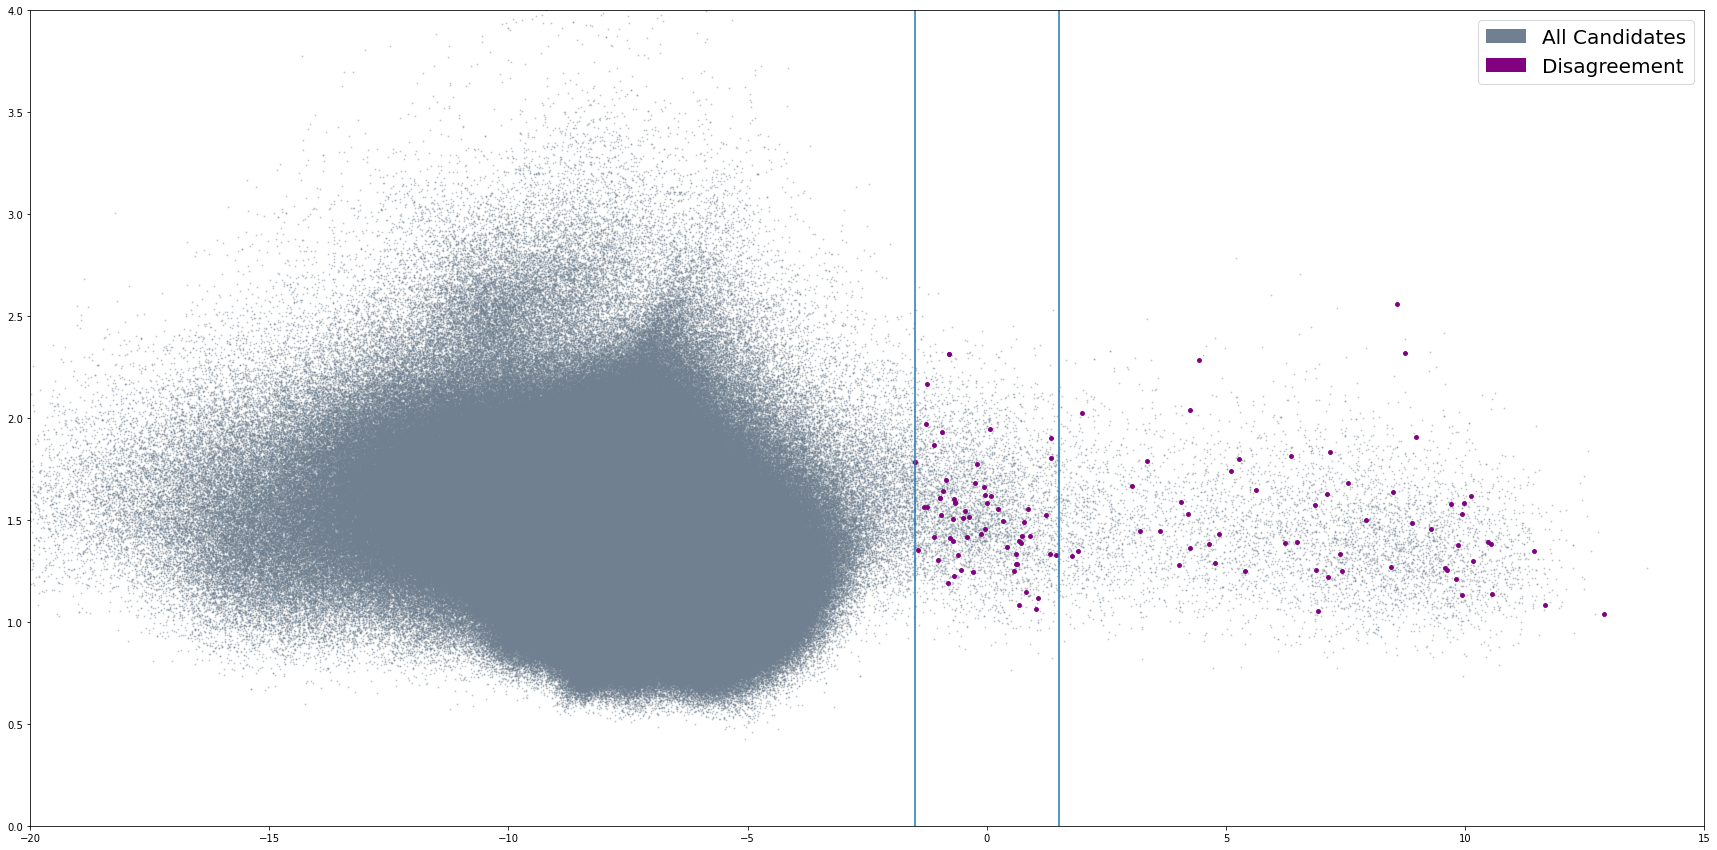

In [115]:
plt.figure(figsize=[30,15])
alpha = 1
size = 15
plt.scatter(detections['mean_score'].to_numpy(),detections['std_score'].to_numpy(),color='slategrey',s=1,alpha=0.3)
plt.scatter(sure_disagree_features['mean_score'].to_numpy(),sure_disagree_features['std_score'].to_numpy(),color='purple',s=size,alpha=alpha)
plt.scatter(unsure_disagree_features['mean_score'].to_numpy(),unsure_disagree_features['std_score'].to_numpy(),color='purple',s=size,alpha=alpha)
plt.xlim([-20,15])
plt.ylim([0,4])
plt.axvline(-1.5)
plt.axvline(1.5)
label1 = Patch(facecolor='slategrey',label='All Candidates')
label2 = Patch(facecolor='purple',label='Disagreement')
plt.legend(handles=[label1,label2],prop={'size':20})